In [5]:
from diffmain import GuassianDiffusion
from DataL import *
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb
import unets

[[[0.8156863  0.8352941  0.85882354]
  [0.81960785 0.8392157  0.8627451 ]
  [0.8235294  0.8392157  0.88235295]
  ...
  [0.60784316 0.6627451  0.6117647 ]
  [0.60784316 0.6627451  0.6117647 ]
  [0.60784316 0.6627451  0.6117647 ]]

 [[0.81960785 0.8392157  0.8627451 ]
  [0.81960785 0.8352941  0.87058824]
  [0.827451   0.84313726 0.8862745 ]
  ...
  [0.6117647  0.6666667  0.6156863 ]
  [0.6117647  0.6666667  0.6156863 ]
  [0.60784316 0.6627451  0.6117647 ]]

 [[0.81960785 0.8352941  0.87058824]
  [0.8235294  0.8392157  0.8745098 ]
  [0.83137256 0.84705883 0.8901961 ]
  ...
  [0.60784316 0.6627451  0.6117647 ]
  [0.60784316 0.6627451  0.6117647 ]
  [0.60784316 0.6627451  0.6117647 ]]

 ...

 [[0.6039216  0.69411767 0.6156863 ]
  [0.6039216  0.69411767 0.6156863 ]
  [0.6        0.6901961  0.6117647 ]
  ...
  [0.77254903 0.8        0.77254903]
  [0.78039217 0.8039216  0.7882353 ]
  [0.8        0.8235294  0.80784315]]

 [[0.60784316 0.69411767 0.6117647 ]
  [0.60784316 0.69411767 0.6117647 ]


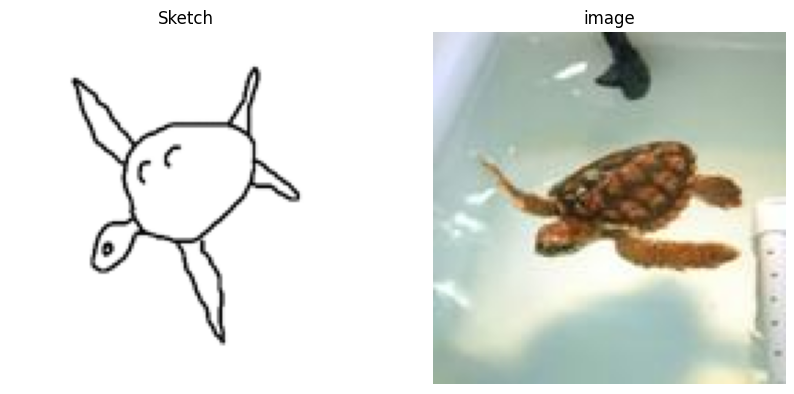

In [2]:

photos_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/photo/resized'
sketches_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/sketch/resized'

transform = transforms.Compose([transforms.ToTensor()]) 
SketchySet = SketchyDataset(sketches_dir, photos_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(SketchySet, batch_size=256)


i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
sk = sk.numpy()
im = im.numpy()

sk=np.array(sk).transpose((1,2,0))
im=np.array(im).transpose((1,2,0))
print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()



In [14]:
class latent_diffusion(nn.Module, GuassianDiffusion):
    def __init__(self, latent_dim,hidden_dim,input_dim):
        super(latent_diffusion, self).__init__()
        output_dim = input_dim
        #TODO
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )

        self.diffusion = GuassianDiffusion(timesteps=1000, device='cpu')

        self.Unet = unets.__dict__["UNet"](
                    image_size=128,
                    in_channels=3,
                    out_channels=3)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 256, 256))
        )

    def forward(self, x):
        encoded = self.encoder(x)

        encoded.view
        t = torch.randint(self.diffusion.timesteps, (len(x),), dtype=torch.int64)
        diffused = self.diffusion.sample_from_forward_process(encoded, t)

        xt, eps = self.diffusion.sample_from_forward_process(x, t)
        denoised = self.Unet(xt, t, y = None)
        
        decoded = self.decoder(denoised)
        return decoded

In [16]:
from torchsummary import summary

input_dim = 256*256 * 3
hidden_dim = 80*80
latent_dim = 64*64 * 3

autoencoder = latent_diffusion(latent_dim, hidden_dim, input_dim)
summary(autoencoder, (3,256,256))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1536x256 and 12288x6400)